# Generate Synthetic Time Histories for Wind Power Generation

## Background: 
The University of Illinois has a power purchase agreement with Rail Splitter Wind Farm in Lincoln, IL. 

* The wind farm has a capacity of 100.5 MW from 67 GE 1.5 MW wind turbines.
* UIUC buys 8.6% of power generated at 4 cents/kWh or $\$4$/MWh
* The agreement is for 10 years (2016-2026). 
* Info about the specific wind turbines is available here: https://en.wind-turbine-models.com/turbines/656-general-electric-ge-1.5xle 


## About the data

The data used in this analysis was obtained from a subdivision of the National Oceanic and Atmospheric Administration (NOAA), National Centers for Environmental Information (NECI). The data was collected by a land-based weather station located at the Lincoln Illinois Airport for the years of 2010-2019. 

https://www.ncdc.noaa.gov/data-access

The data is stored on Box rather than locally. 

## Set up the Box API to access data

In [4]:
%%capture 
!pip install boxsdk
# %%capture captures the output from pip install... comment out if there are installation issues.

In [65]:
from boxsdk import Client, OAuth2

# Defines client ID, secrete, and developer token
CLIENT_ID = 'ey8yzp3yxanb3jjujb2s95c1bnouz2o8'
CLIENT_SECRET = 'VGGJjHGWfBm0MHq1xIqncxZDolelVIDP'
ACCESS_TOKEN = '1vjiMFfmp7icbIr5XKKDwgHhywoQZmgq' # only valid for 60 minutes...?

# Creates the client instance
oauth2 = OAuth2(CLIENT_ID, CLIENT_SECRET, access_token=ACCESS_TOKEN)

client = Client(oauth2)

In [66]:
# Folder IDs 
gridload_id = 92229909420
solarfarm_id = 92974470362
solarmodel_id = 92182116657
steam_id = 92620146668
weather_id = 90175362988

In [67]:
weather_folder = client.folder(folder_id=weather_id).get_items()
for data in weather_folder:
    print('{0} {1} is named "{2}"'.format(data.type.capitalize(), data.id, data.name))

File 555305816779 is named "cu_weather2010.csv"
File 555299948418 is named "cu_weather2013.csv"
File 555306577234 is named "cu_weather2014.csv"
File 555305375271 is named "cu_weather2015.csv"
File 555306307526 is named "cu_weather2017.csv"
File 555299962271 is named "cu_weather2018.csv"
File 578216725033 is named "lincoln_weather_data.csv"
File 540635643784 is named "willard_prec.csv"
File 540636908349 is named "willard_temp.csv"
File 540627539717 is named "willard_weather_data.csv"


In [75]:
# Gets the file with the data
lincoln_file = client.file(file_id=578216725033)

# Import to a pandas dataframe
import pandas as pd

path = './lincoln_weather.csv'
with open(path, 'wb') as file:
    lincoln_file.download_to(file)

lincoln_wind = pd.read_csv(path, usecols=['HourlyWindSpeed', 'HourlyDryBulbTemperature', 
                                          'HourlyStationPressure','HourlyRelativeHumidity',
                                          'DATE'])

# Removes the file from the local directory
!rm -rf lincoln_weather.csv

## Data Processing

### Step 1: Resample by hour

In [76]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_funcs import to_float

In [77]:
# convert to datetime
lincoln_wind.DATE = pd.to_datetime(lincoln_wind.DATE)

# rename columns
lincoln_wind.rename(columns={'DATE':'time',
                             'HourlyDryBulbTemperature': 'temp',
                             'HourlyRelativeHumidity':'RH', 
                             'HourlyStationPressure':'pressure',
                             'HourlyWindSpeed': 'u'}, inplace=True)

In [78]:
# Verify that the dataframe has float values
lincoln_wind = to_float(lincoln_wind, 'temp')
lincoln_wind = to_float(lincoln_wind, 'u')
lincoln_wind = to_float(lincoln_wind, 'RH')
lincoln_wind = to_float(lincoln_wind, 'pressure')

lincoln_wind.index = pd.to_datetime(lincoln_wind.time)


In [79]:
# resample by hour to get single measurements for each hour
lincoln_wind = lincoln_wind.resample('H').mean()

lincoln_wind.head(5)

,temp,RH,pressure,u
time,,,,
2010-12-11 00:00:00,34.333333,90.666667,29.306667,6.000000
2010-12-11 01:00:00,32.000000,95.333333,29.293333,5.666667
2010-12-11 02:00:00,33.000000,95.333333,29.283333,8.333333
2010-12-11 03:00:00,34.000000,91.666667,29.270000,7.666667
2010-12-11 04:00:00,34.000000,93.000000,29.250000,6.666667


## Calculate the Power to Campus

This analysis will use the following model from 
>H. E. Garcia et al., “Nuclear Hybrid Energy Systems Regional Studies: West Texas & Northeastern Arizona,” Idaho National Lab. (INL), Idaho Falls, ID (United States), INL/EXT-15-34503, Apr. 2015.

#### Operating Regimes
* Above the cut-out and below the cut-in speeds, the turbines produce no power. 
* Between the rated speed and the cut-out speeds the turbines produce a constant rated power.
* Between the cut-in speed and the rated speeds the turbines produce power given by 

$P = 0.5\eta\rho U_h^3\frac{\pi d^2}{4} [\text{W}_e]$

_(in Baker et. al they claim this formula gives the value in MW, this appears to be untrue)_

where 
* $\eta$ is the conversion efficiency (not given for these turbines, so we assume 35%)
* $\rho$ is the density of air at the location (based on temperature)
* $d$ is the diameter of the turbine (2 x blade length). 


The density of air, $\rho$, can be calculated with the following: 

$\rho = \frac{P_{dry}}{R_{dry}T} + \frac{P_{vapor}}{R_{vapor}T}$

The vapor pressure $P_{vapor}$ can be calculated using the Clausius-Clapeyron Equation which gives the saturation vapor pressure over water.

$P_{vapor} = e_s * RH$

$e_s = 0.6112e^{\frac{17.67T}{T+243.5}} [\text{kPa}]$
>Iribarne, J. V., and W. L. Godson 1981. Atmospheric Thermodynamics. D. Reidel, . p. 65.

* $T$ : Temperature in $^\circ C$
* $R_{dry}$ : 287.058 J/(kg·K)
* $R_{vapor}$ : 461.495 J/(kg·K)
* $RH$ : Relative Humidity


In [80]:
# convert the temperature to Celsius
to_celsius = lambda T : (T-32)*5/9

lincoln_wind['temp'] = lincoln_wind['temp'].apply(to_celsius)

lincoln_wind.head(5)

,temp,RH,pressure,u
time,,,,
2010-12-11 00:00:00,1.296296,90.666667,29.306667,6.000000
2010-12-11 01:00:00,0.000000,95.333333,29.293333,5.666667
2010-12-11 02:00:00,0.555556,95.333333,29.283333,8.333333
2010-12-11 03:00:00,1.111111,91.666667,29.270000,7.666667
2010-12-11 04:00:00,1.111111,93.000000,29.250000,6.666667


In [84]:
# convert pressure to Pascals
to_pa = lambda P: P*3386.38867

lincoln_wind['pressure'] = lincoln_wind['pressure'].apply(to_pa)
lincoln_wind.head(5)

,temp,RH,pressure,u,rho
time,,,,,
2010-12-11 00:00:00,1.296296,90.666667,99243.763955,6.000000,-0.291581
2010-12-11 01:00:00,0.000000,95.333333,99198.612107,5.666667,-0.280512
2010-12-11 02:00:00,0.555556,95.333333,99164.748220,8.333333,-0.291447
2010-12-11 03:00:00,1.111111,91.666667,99119.596371,7.666667,-0.291096
2010-12-11 04:00:00,1.111111,93.000000,99051.868597,6.666667,-0.295336


In [87]:
# calculate air density

# define constants
Rv = 461.495
Rd = 287.058

# define functions
es = lambda T: 611.2*np.exp(17.67*T/(T+243.5)) # saturation vapor pressure over water
rho = lambda T, P, Rh, Pv: (es(T)*(Rh/100))/(Rv*(T+273.15))+(P-(es(T)*(Rh/100)))/(Rd*(T+273.15)) # density of air 


density = {'rho':[]}
for i in range(len(lincoln_wind)):
    T = lincoln_wind.iloc[i]['temp']
    P = lincoln_wind.iloc[i]['pressure']
    Rh = lincoln_wind.iloc[i]['RH']
    Pv = es(T)
    density['rho'].append(rho(T, P, Rh, Pv))
lincoln_wind['rho'] = density['rho']

lincoln_wind.head(5)

,temp,RH,pressure,u,rho
time,,,,,
2010-12-11 00:00:00,1.296296,90.666667,99243.763955,6.000000,1.256807
2010-12-11 01:00:00,0.000000,95.333333,99198.612107,5.666667,1.262320
2010-12-11 02:00:00,0.555556,95.333333,99164.748220,8.333333,1.259212
2010-12-11 03:00:00,1.111111,91.666667,99119.596371,7.666667,1.256085
2010-12-11 04:00:00,1.111111,93.000000,99051.868597,6.666667,1.255182


In [89]:
# convert windspeed to m/s

to_ms = lambda u: u/2.237
lincoln_wind['u'] = lincoln_wind['u'].apply(to_ms)

In [115]:
# calculate the power generated

# define constants
N = 67 # the number of wind turbines
d = 82.5 # [m]
u_in = 3.5 # [m/s]
u_out = 20.0 # [m/s]
u_ideal = 11.5
eta = 0.3 # efficiency
ppa = 0.086 # the percentage of purchased power.
pmax = 1.5 # [MW], the rated power for a single turbine

P = lambda U, rho: N*ppa*0.5*eta*rho*(U**3)*(np.pi*d**2/4)/1e6

# calculate all values of power
power = []
for i in range(len(lincoln_wind)):
    U = lincoln_wind.iloc[i]['u']
    rho = lincoln_wind.iloc[i]['rho']
    power.append(P(U, rho))
lincoln_wind['power'] = power

In [116]:
# fix based on cut in and cut out speeds
zero = (lincoln_wind.u <= u_in) | (lincoln_wind.u >= u_out)
peak = (lincoln_wind.u > u_ideal) & (lincoln_wind.u < u_out)

lincoln_wind['power'].mask(zero, 0, inplace=True)
lincoln_wind['power'].mask(peak, N*ppa*pmax, inplace=True)

$\eta$ was given in Baker et. al and Garcia et. al as 0.35, corresponding to a 35% conversion efficiency. This was too high the the turbines at the Rail Splitter farm because it exceeded the rated power of the individual turbines. _Try it yourself by changing eta to 0.35_.

The efficiency for UIUC's particular case is closer to 30% 

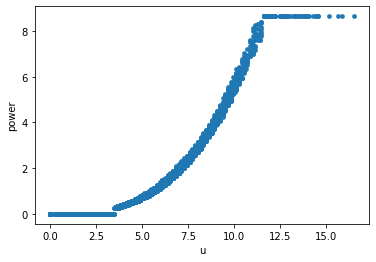

In [118]:
lincoln_wind.plot(kind='scatter', x='u', y='power', lw=0.25)
plt.show()

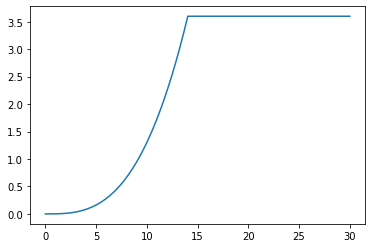

In [103]:
u = np.linspace(0, 30, 1000)
rho = 1.17
n = 0.35
d = 90
pwr = lambda U: 0.5*n*rho*U**3*(np.pi*d**2/4)/1e6
pw = [pwr(s) if s < 14 else 3.6 for s in u]
plt.plot(u, pw)

### Step 2: Group by year

In [35]:
grouped = lincoln_wind.groupby(lincoln_wind.index.year)
df11 = grouped.get_group(2011)
df12 = grouped.get_group(2012)
df13 = grouped.get_group(2013)
df14 = grouped.get_group(2014)
df15 = grouped.get_group(2015)
df16 = grouped.get_group(2016)
df17 = grouped.get_group(2017)
df18 = grouped.get_group(2018)

In [36]:
df11.head(5)

,HourlyWindSpeed
DATE,
2011-01-01 00:00:00,9.333333
2011-01-01 01:00:00,8.000000
2011-01-01 02:00:00,5.666667
2011-01-01 03:00:00,8.666667
2011-01-01 04:00:00,8.666667


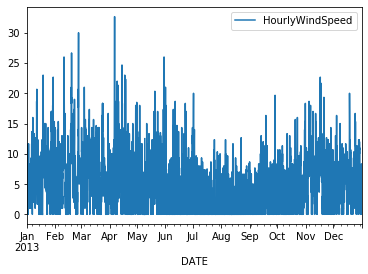

In [41]:
df13.plot()